In [1]:
import metnum
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
total_train = pd.read_csv("../data/train.csv")

In [3]:
def runKNN(k, train, train_labels, values, values_labels):
    clf = metnum.KNNClassifier(k)
    clf.fit(train, train_labels)
    predict_labels = clf.predict(values)
    return accuracy_score(values_labels, predict_labels)

In [4]:
def runKNNWithPCA(alpha, k, train, train_labels, values, values_labels):
    pca = metnum.PCA(alpha)
    pca.fit(train)
    train = pca.transform(train)
    values = pca.transform(values)
    return runKNN(k, train, train_labels, values, values_labels)

In [5]:
def runKFold(k_fold, k, X, y, alpha=0):
    blockSize = int(X.shape[0] / k)
    acc = 0
    for i in range(k_fold):

        limite_1 = blockSize*i
        limite_2 = min(X.shape[0], blockSize*(i+1))

        train, train_labels = np.concatenate((X[0:limite_1], X[limite_2:])), np.concatenate((y[0:limite_1], y[limite_2:]))
        values, values_labels = X[limite_1:limite_2], y[limite_1:limite_2]

        if (alpha == 0):
            acc += runKNN(k, train, train_labels, values, values_labels)
        else:
            acc += runKNNWithPCA(alpha, k, train, train_labels, values, values_labels)
    return acc / k_fold

In [6]:
def runMultiSizeExperiment(data, start, step, k_fold, k, alpha=0):
    size = data.shape[0]
    result = pd.DataFrame(columns = ['Size', 'Accuracy'])
    limits = np.append(np.arange(start, size, step), size)
    for limit in tqdm(limits):
        df_train = total_train[:limit]
        X = df_train[df_train.columns[1:]].values
        y = df_train["label"].values.reshape(-1, 1)
        
        acc = runKFold(k_fold, k, X, y, alpha)
        result = result.append({'Size': limit, 'Accuracy': acc}, ignore_index = True)
    return result.astype({"Size": int, "Accuracy": np.float64})

In [7]:
def run(train, start, step, k_fold, k, alpha=0):
    data = runMultiSizeExperiment(train, start, step, k_fold, k, alpha)
    
    fileName = './resultados/multi_size_' + str(k_fold) + '_' + str(k)
    if (alpha > 0):
        fileName += '_' + str(alpha)
    fileName += '.csv'

    data.to_csv(fileName, index=False)
    return data

In [40]:
def graficar(data, labels, title):
    fig = plt.figure(figsize=(18,12), dpi= 60)
    
    for i in range(len(data)):
        plt.plot(data[i].Size, data[i].Accuracy, label=labels[i])

    plt.xticks(fontsize=15)
    plt.yticks(np.arange(0.7, 1.01, 0.05), fontsize=15)
    plt.title(title, fontdict={'size':20})
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Tamaño de muestra', fontsize=15)
    plt.grid(linestyle='--', alpha=1)
    plt.xlim(4000, 43000)
    plt.ylim(0.7, 1)
    plt.legend(fontsize=15)
    plt.show()

In [9]:
train = total_train
start = 5000
step = 5000
k_fold = 5

In [10]:
ks = np.append(np.arange(5, 21, 5), np.arange(30, 51, 10))
for k in tqdm(ks):
    run(train, start, step, k_fold, k)

100%|██████████| 7/7 [3:33:09<00:00, 1827.03s/it]


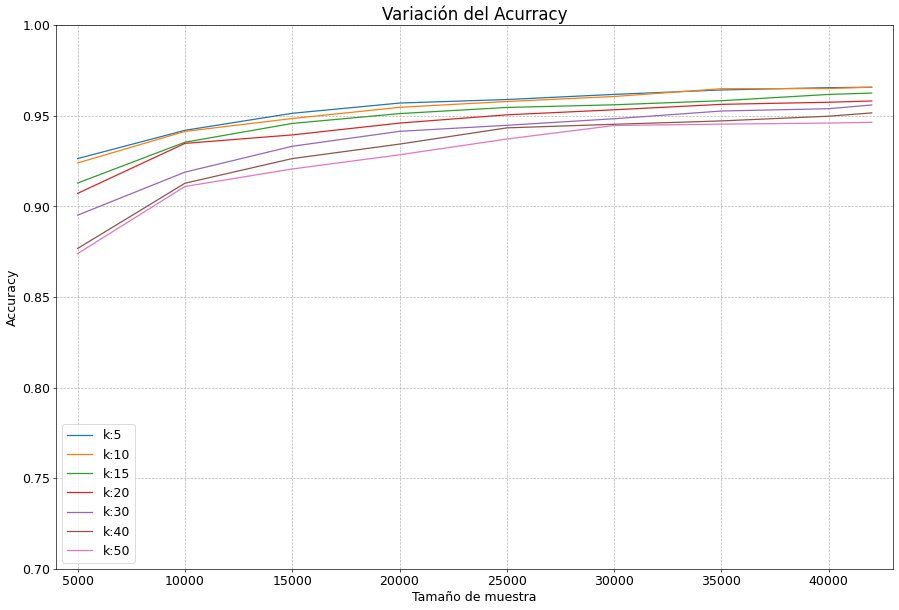

In [41]:
datas = []
labels = []
for k in ks:
    fileName = "./resultados/multi_size_5_" + str(k) + ".csv"
    label = "k:" + str(k)
    data = pd.read_csv(fileName)
    datas.append(data)
    labels.append(label)
graficar(datas, labels, 'Variación del Acurracy')

In [14]:
k = 5
alphas = np.append(np.arange(5, 21, 5), np.arange(30, 51, 10))
for alpha in tqdm(alphas):
    run(train, start, step, k_fold, k, alpha)

100%|██████████| 7/7 [32:47<00:00, 281.13s/it]


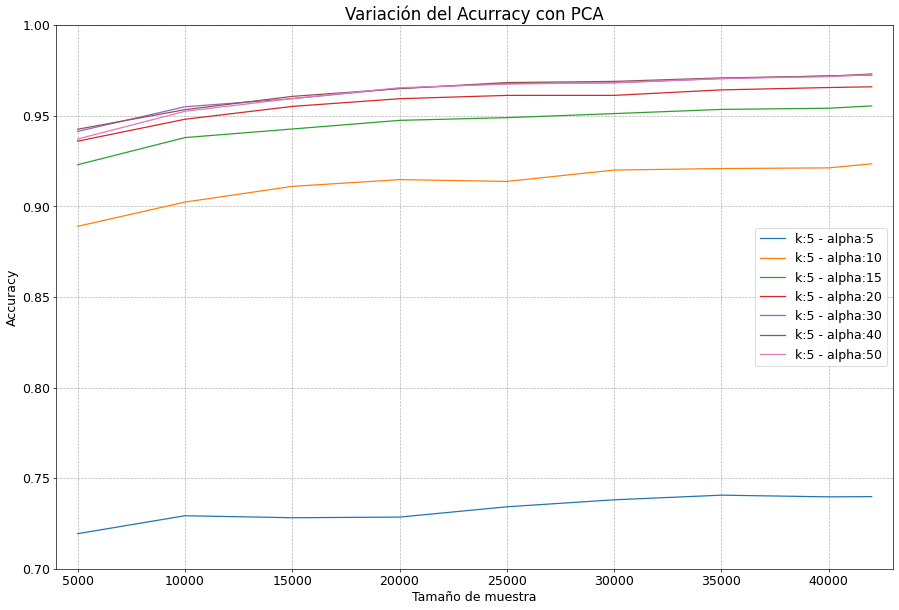

In [42]:
k = 5
datas = []
labels = []
for alpha in alphas:
    fileName = "./resultados/multi_size_5_" + str(k) + "_" + str(alpha) + ".csv"
    label = "k:" + str(k) + " - alpha:" + str(alpha)
    data = pd.read_csv(fileName)
    datas.append(data)
    labels.append(label)
graficar(datas, labels, 'Variación del Acurracy con PCA')